In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

In [105]:
pre_df = pd.read_csv('../../data/cleaned/cleaned_vessel_calls.csv')

In [106]:
# preprocess dataframe - duration and month
pre_df["arrivalDate"] = pd.to_datetime(pre_df["arrivalDate"])
pre_df["sailingDate"] = pd.to_datetime(pre_df["sailingDate"])
pre_df["duration"] = pd.to_datetime(pre_df["sailingDate"]) - pd.to_datetime(pre_df["arrivalDate"])
pre_df["month"] = pre_df["arrivalDate"].dt.month

In [107]:
pre_df['duration'] = pre_df['duration'] / pd.Timedelta(days=1)

In [108]:
# drop null values in df
pre_df.dropna(inplace=True)

In [109]:
# preprocess data
# sort by imo number
pre_df.sort_values(by=["IMO", "arrivalDate"], inplace=True)
pre_df['next_unlocode'] = pre_df.groupby('IMO')['place.unlocode'].shift(-1)
pre_df['is_last_imo'] = pre_df['IMO'] != pre_df['IMO'].shift(-1)
pre_df = pre_df[~pre_df["is_last_imo"]]
pre_df = pre_df[pre_df["Event_Type"] != "ARRIVAL"]

In [110]:
pre_df.columns

Index(['arrivalDate', 'sailingDate', 'place.placeName', 'place.unlocode',
       'place.placeType', 'place.countryName', 'Timestamp', 'Event_Type',
       'IMO', 'vessel.vesselName', 'vessel.vesselType', 'duration', 'month',
       'next_unlocode', 'is_last_imo'],
      dtype='object')

In [111]:
pre_df

,arrivalDate,sailingDate,place.placeName,place.unlocode,place.placeType,place.countryName,Timestamp,Event_Type,IMO,vessel.vesselName,vessel.vesselType,duration,month,next_unlocode,is_last_imo
314761,2023-01-18 14:10:05,2023-01-26 04:05:00,Los Angeles,USLAX,Port,United States of America,2023-01-26T04:05:00,DEPARTURE,1026764,Max 08,Vessel Type (unspecified),7.579803,1,CNJGY,False
314763,2023-02-22 07:17:58,2023-02-23 18:56:16,Jiangyin,CNJGY,Port,People's Republic of China,2023-02-23T18:56:16,DEPARTURE,1026764,Max 08,Vessel Type (unspecified),1.484931,2,CNTXG,False
314765,2023-03-02 16:00:39,2023-03-03 12:31:09,Tianjin Xingang Port,CNTXG,Port,People's Republic of China,2023-03-03T12:31:09,DEPARTURE,1026764,Max 08,Vessel Type (unspecified),0.854514,3,CNQAW,False
314767,2023-03-04 21:02:13,2023-03-05 11:45:29,Qianwan,CNQAW,Sub Port,People's Republic of China,2023-03-05T11:45:29,DEPARTURE,1026764,Max 08,Vessel Type (unspecified),0.613380,3,CNMSN,False
314769,2023-03-06 23:30:18,2023-03-08 00:00:46,Meishan,CNMSN,Sub Port,People's Republic of China,2023-03-08T00:00:46,DEPARTURE,1026764,Max 08,Vessel Type (unspecified),1.021157,3,CNNSA,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12569,2023-09-05 05:50:48,2023-09-06 02:46:03,Port Klang (Pelabuhan Klang),MYPKG,Port,Malaysia,2023-09-06T02:46:03,DEPARTURE,9951135,Asterios,fully cellular containership,0.871701,9,INMAA,False
12571,2023-09-10 16:43:35,2023-09-11 20:02:20,Chennai (ex Madras),INMAA,Port,India,2023-09-11T20:02:20,DEPARTURE,9951135,Asterios,fully cellular containership,1.138021,9,BDCGP,False
12573,2023-09-15 05:31:56,2023-09-17 05:28:29,Chittagong (Chattogram),BDCGP,Port,Bangladesh,2023-09-17T05:28:29,DEPARTURE,9951135,Asterios,fully cellular containership,1.997604,9,THLCH,False
12575,2023-09-24 15:15:36,2023-09-25 08:23:38,Laem Chabang,THLCH,Port,Thailand,2023-09-25T08:23:38,DEPARTURE,9951135,Asterios,fully cellular containership,0.713912,9,SGSIN,False


In [112]:
pre_df = pre_df.drop(columns=["is_last_imo", "Event_Type", "Timestamp", "vessel.vesselName", "IMO", "arrivalDate", "sailingDate"])
pre_df

,place.placeName,place.unlocode,place.placeType,place.countryName,vessel.vesselType,duration,month,next_unlocode
314761,Los Angeles,USLAX,Port,United States of America,Vessel Type (unspecified),7.579803,1,CNJGY
314763,Jiangyin,CNJGY,Port,People's Republic of China,Vessel Type (unspecified),1.484931,2,CNTXG
314765,Tianjin Xingang Port,CNTXG,Port,People's Republic of China,Vessel Type (unspecified),0.854514,3,CNQAW
314767,Qianwan,CNQAW,Sub Port,People's Republic of China,Vessel Type (unspecified),0.613380,3,CNMSN
314769,Meishan,CNMSN,Sub Port,People's Republic of China,Vessel Type (unspecified),1.021157,3,CNNSA
...,...,...,...,...,...,...,...,...
12569,Port Klang (Pelabuhan Klang),MYPKG,Port,Malaysia,fully cellular containership,0.871701,9,INMAA
12571,Chennai (ex Madras),INMAA,Port,India,fully cellular containership,1.138021,9,BDCGP
12573,Chittagong (Chattogram),BDCGP,Port,Bangladesh,fully cellular containership,1.997604,9,THLCH
12575,Laem Chabang,THLCH,Port,Thailand,fully cellular containership,0.713912,9,SGSIN


In [113]:
df = pre_df.rename(columns={'place.unlocode':'current_unlocode', 'place.placeName':'port_name','vessel.vesselType':'vessel_type', 'place.placeType': 'place_type', 'place.countryName': 'country_name'})
df

,port_name,current_unlocode,place_type,country_name,vessel_type,duration,month,next_unlocode
314761,Los Angeles,USLAX,Port,United States of America,Vessel Type (unspecified),7.579803,1,CNJGY
314763,Jiangyin,CNJGY,Port,People's Republic of China,Vessel Type (unspecified),1.484931,2,CNTXG
314765,Tianjin Xingang Port,CNTXG,Port,People's Republic of China,Vessel Type (unspecified),0.854514,3,CNQAW
314767,Qianwan,CNQAW,Sub Port,People's Republic of China,Vessel Type (unspecified),0.613380,3,CNMSN
314769,Meishan,CNMSN,Sub Port,People's Republic of China,Vessel Type (unspecified),1.021157,3,CNNSA
...,...,...,...,...,...,...,...,...
12569,Port Klang (Pelabuhan Klang),MYPKG,Port,Malaysia,fully cellular containership,0.871701,9,INMAA
12571,Chennai (ex Madras),INMAA,Port,India,fully cellular containership,1.138021,9,BDCGP
12573,Chittagong (Chattogram),BDCGP,Port,Bangladesh,fully cellular containership,1.997604,9,THLCH
12575,Laem Chabang,THLCH,Port,Thailand,fully cellular containership,0.713912,9,SGSIN


In [114]:
# data statistics
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170752 entries, 314761 to 12577
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   port_name         170752 non-null  object 
 1   current_unlocode  170752 non-null  object 
 2   place_type        170752 non-null  object 
 3   country_name      170752 non-null  object 
 4   vessel_type       170752 non-null  object 
 5   duration          170752 non-null  float64
 6   month             170752 non-null  int32  
 7   next_unlocode     170752 non-null  object 
dtypes: float64(1), int32(1), object(6)
memory usage: 11.1+ MB


In [115]:
# print out the stats related to port appearance
print(df['current_unlocode'].value_counts().describe())

count    1772.000000
mean       96.361174
std       350.567438
min         1.000000
25%         3.000000
50%        11.000000
75%        54.000000
max      8980.000000
Name: count, dtype: float64


In [116]:
# Calculate frequency of each port for thresholding
port_counts = pd.concat([df['current_unlocode'], df['next_unlocode']]).value_counts()

threshold = 1000
print(threshold)

# Filter ports that meet the threshold
valid_ports_df = port_counts[port_counts >= threshold]
valid_ports = port_counts[port_counts >= threshold].index
# Keep only rows where both current and next ports are in valid_ports
filtered_df = df[(df['current_unlocode'].isin(valid_ports)) & (df['next_unlocode'].isin(valid_ports))]
valid_ports_df


1000


SGSIN     17961
PA PCN     6705
USLGB      6387
CNSGH      6015
KRBNP      5579
          ...  
ECESM      1065
SADMM      1053
PECLL      1023
CNMWN      1018
CNCWN      1000
Name: count, Length: 71, dtype: int64

In [117]:
# uniqueness check
print(len(valid_ports))
print(len(set(valid_ports)))

71
71


In [118]:
# value counts of filtered_df
vc_filtered_df = pd.concat([filtered_df['current_unlocode'], filtered_df['next_unlocode']]).value_counts()
vc_filtered_df

SGSIN    11943
CNBEI     5078
KRBNP     4840
CNYSN     4747
CNSGH     4735
         ...  
AUPOR      389
SADMM      376
ZADUR      274
BRSSZ      223
PECLL      209
Name: count, Length: 71, dtype: int64

In [119]:
# Select a certain number of samples for each port
# Initialize an empty list to store the rows before creating the final DataFrame
rows_to_add = []

# Track how many times each port has been added
port_usage = {port: 0 for port in valid_ports}

# Shuffle the data to randomize the sampling
filtered_df = filtered_df.sample(frac=1, random_state=42)

for _, row in filtered_df.iterrows():
    current_port = row['current_unlocode']
    next_port = row['next_unlocode']
    # Check if both ports in the row can still be added
    if port_usage[current_port] < 200 and port_usage[next_port] < 200:
        rows_to_add.append(row)
        # Update the usage count for both ports
        port_usage[current_port] += 1
        port_usage[next_port] += 1

        # Stop adding if both have reached the limit
        if all(count >= 100 for count in port_usage.values()):
            break

# Create the final DataFrame from the list of rows
balanced_df = pd.DataFrame(rows_to_add)

# Reset index after all operations
balanced_df = balanced_df.reset_index(drop=True)

# Print value counts to confirm balancing
df_bal_counts = pd.concat([balanced_df['current_unlocode'], balanced_df['next_unlocode']]).value_counts()
df_bal_counts.describe()
df_bal_counts

USHOU    201
SGSIN    201
ECESM    201
GBSOU    201
CAVAN    201
        ... 
ZADUR    122
CNMWN    114
CNCWN    106
PECLL     85
BRSSZ     83
Name: count, Length: 71, dtype: int64

In [120]:
print(df_bal_counts.describe())
df_bal_counts.quantile(0.15)

count     71.000000
mean     187.521127
std       28.254890
min       83.000000
25%      200.000000
50%      200.000000
75%      200.000000
max      201.000000
Name: count, dtype: float64


164.5

In [121]:
threshold = 200
# filter ports again to remove ports in balanced_df that are not above a certain threshold from df_bal_counts
valid_ports_bal_df = df_bal_counts[df_bal_counts >= threshold]
valid_ports_bal = df_bal_counts[df_bal_counts >= threshold].index
# Keep only rows where both current and next ports are in valid_ports
filtered_bal_df = balanced_df[(balanced_df['current_unlocode'].isin(valid_ports_bal)) & (balanced_df['next_unlocode'].isin(valid_ports_bal))]
valid_ports_bal_df

USHOU     201
SGSIN     201
ECESM     201
GBSOU     201
CAVAN     201
CNTXG     201
INMUN     201
DEBRV     201
THLCH     200
CNYTN     200
CNSHK     200
TWKHH     200
LKCMB     200
AEKHL     200
KRBNP     200
USPNJ     200
MYPKG     200
BEZEE     200
USCHS     200
CNQAW     200
BEANR     200
CNNSA     200
KRPTK     200
JPYOK     200
USBAL     200
KRKAN     200
NLRTM     200
JPUKB     200
PAONX     200
AUPBN     200
USTIW     200
MXZLO     200
KRYOS     200
VNTOT     200
MXLZC     200
KRUSN     200
USLGB     200
CNSGH     200
CNXMG     200
KRONS     200
USSAV     200
AEJEA     200
JPNGO     200
JPTYO     200
CNZOS     200
INNSA     200
USLAX     200
PA PCN    200
USOAK     200
HKHKG     200
MYTPP     200
CNYSN     200
FRLEH     200
CNBEI     200
Name: count, dtype: int64

In [122]:
df = filtered_bal_df

In [123]:
filtered_bal_df

,port_name,current_unlocode,place_type,country_name,vessel_type,duration,month,next_unlocode
0,Yeosu,KRYOS,Port,Republic of Korea,Combined chemical and oil tanker,2.870428,4,KRONS
1,Yantian Port,CNYTN,Port,People's Republic of China,fully cellular containership,0.878356,12,PA PCN
3,Ulsan,KRUSN,Port,Republic of Korea,vehicle carrier,0.325683,7,USTIW
6,Long Beach,USLGB,Port,United States of America,vehicle carrier,0.655486,6,USLGB
7,Shanghai,CNSGH,Port,People's Republic of China,fully cellular containership,0.510532,7,TWKHH
...,...,...,...,...,...,...,...,...
6566,Tacoma,USTIW,Port,United States of America,bulk carrier,0.229595,10,USTIW
6575,Colon,PAONX,Port,Panama,fully cellular containership,0.587616,2,PAONX
6585,Tacoma,USTIW,Port,United States of America,fully cellular containership,5.807292,9,USTIW
6595,Colon,PAONX,Port,Panama,vehicle carrier,0.558692,2,PAONX


In [124]:
df['country_name'].value_counts()

country_name
People's Republic of China    875
United States of America      842
Republic of Korea             553
Japan                         330
Belgium                       197
Panama                        182
Mexico                        164
Malaysia                      149
India                         148
United Arab Emirates          134
Thailand                      102
Sri Lanka                     100
Ecuador                        97
Republic of Singapore          93
Taiwan, China                  93
Hong Kong, S.A.R., China       90
Germany                        87
United Kingdom                 85
Canada                         81
France                         78
Vietnam                        71
Netherlands                    60
Australia                      42
Name: count, dtype: int64

In [125]:
# Encode categorical features
label_encoders = {}
for column in ['port_name', 'place_type', 'vessel_type']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

C:\Users\syeda\AppData\Local\Temp\ipykernel_26360\3732540556.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column].astype(str))
C:\Users\syeda\AppData\Local\Temp\ipykernel_26360\3732540556.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column].astype(str))
C:\Users\syeda\AppData\Local\Temp\ipykernel_26360\3732540556.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [126]:
# manually map everything to integers for unlocode
# Combine both columns to find all unique ports
all_ports = pd.concat([df['current_unlocode'], df['next_unlocode']])

# Create unique identifiers for each port
unique_ports = all_ports.unique()
port_to_id = {port: i for i, port in enumerate(unique_ports)}

df['encoded_current_unlocode'] = df['current_unlocode'].map(port_to_id)
df['encoded_next_unlocode'] = df['next_unlocode'].map(port_to_id)

# Print the first few rows of the DataFrame to verify the encoding
print(df.head())


   port_name current_unlocode  place_type                country_name  \
0         50            KRYOS           0           Republic of Korea   
1         49            CNYTN           0  People's Republic of China   
3         45            KRUSN           0           Republic of Korea   
6         20            USLGB           0    United States of America   
7         37            CNSGH           0  People's Republic of China   

   vessel_type  duration  month next_unlocode  encoded_current_unlocode  \
0            0  2.870428      4         KRONS                         0   
1            7  0.878356     12        PA PCN                         1   
3           14  0.325683      7         USTIW                         2   
6           14  0.655486      6         USLGB                         3   
7            7  0.510532      7         TWKHH                         4   

   encoded_next_unlocode  
0                      6  
1                     15  
3                     52  
6 

C:\Users\syeda\AppData\Local\Temp\ipykernel_26360\2382646095.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encoded_current_unlocode'] = df['current_unlocode'].map(port_to_id)
C:\Users\syeda\AppData\Local\Temp\ipykernel_26360\2382646095.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encoded_next_unlocode'] = df['next_unlocode'].map(port_to_id)


In [127]:
ports = df[['current_unlocode', 'encoded_current_unlocode', 'next_unlocode', 'encoded_next_unlocode']]
ports

,current_unlocode,encoded_current_unlocode,next_unlocode,encoded_next_unlocode
0,KRYOS,0,KRONS,6
1,CNYTN,1,PA PCN,15
3,KRUSN,2,USTIW,52
6,USLGB,3,USLGB,3
7,CNSGH,4,TWKHH,29
...,...,...,...,...
6566,USTIW,52,USTIW,52
6575,PAONX,50,PAONX,50
6585,USTIW,52,USTIW,52
6595,PAONX,50,PAONX,50


In [128]:
df = df.drop(columns=['current_unlocode', 'next_unlocode', 'place_type'])

In [129]:
df

,port_name,country_name,vessel_type,duration,month,encoded_current_unlocode,encoded_next_unlocode
0,50,Republic of Korea,0,2.870428,4,0,6
1,49,People's Republic of China,7,0.878356,12,1,15
3,45,Republic of Korea,14,0.325683,7,2,52
6,20,United States of America,14,0.655486,6,3,3
7,37,People's Republic of China,7,0.510532,7,4,29
...,...,...,...,...,...,...,...
6566,41,United States of America,4,0.229595,10,52,52
6575,8,Panama,7,0.587616,2,50,50
6585,41,United States of America,7,5.807292,9,52,52
6595,8,Panama,14,0.558692,2,50,50


In [130]:
# Split the data by vessel type
country_names = df['country_name'].unique()
results = {}

# Minimum number of samples per class
min_samples_per_class = 2

# Loop through each vessel type
for country in country_names:
    print(f"Processing vessel type: {country}")
    country_df = df[df['country_name'] == country].drop(columns=['country_name'])
    
    # Prepare features and target variable
    X = country_df.drop(['encoded_next_unlocode'], axis=1)
    y = country_df['encoded_next_unlocode']
    # Check if each class has enough samples
    class_counts = y.value_counts()
    if class_counts.min() < min_samples_per_class:
        # Use simple split without stratification
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    else:
        # Use stratified split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
    
    # Scale the data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Define the model and parameter grid
    model = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [400, 450, 500, 550, 600],
        'max_depth': [15, 20, 25],
        'min_samples_split': [8, 10, 12],
        'min_samples_leaf': [2, 3, 4],
        'max_features': ['log2']
    }
    
    # Grid search with StratifiedKFold
    skf = StratifiedKFold(n_splits=3) if class_counts.min() >= min_samples_per_class else None
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, verbose=2, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Evaluate the best model found by GridSearchCV
    best_model = grid_search.best_estimator_
    train_predictions = best_model.predict(X_train)
    test_predictions = best_model.predict(X_test)
    
    training_accuracy = accuracy_score(y_train, train_predictions) * 100
    validation_accuracy = accuracy_score(y_test, test_predictions) * 100
    
    print(f'Training Accuracy for {country}: {training_accuracy}')
    print(f'Validation Accuracy for {country}: {validation_accuracy}')
    print(f'Best Model for {country}: {grid_search.best_estimator_}')
    
    classification_rep = classification_report(y_test, test_predictions, output_dict=True)
    
    results[country] = {
        'training_accuracy': training_accuracy,
        'validation_accuracy': validation_accuracy,
        'best_model': grid_search.best_estimator_,
        'classification_report': classification_rep,
        'num_entries': len(X_test)
    }

Processing vessel type: Republic of Korea
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Training Accuracy for Republic of Korea: 54.38066465256798
Validation Accuracy for Republic of Korea: 30.630630630630627
Best Model for Republic of Korea: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=3,
                       min_samples_split=12, n_estimators=600, random_state=42)
Processing vessel type: People's Republic of China
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to

Training Accuracy for People's Republic of China: 57.333333333333336
Validation Accuracy for People's Republic of China: 31.71428571428571
Best Model for People's Republic of China: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=400, random_state=42)
Processing vessel type: United States of America
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to

Training Accuracy for United States of America: 60.79207920792079
Validation Accuracy for United States of America: 44.80712166172107
Best Model for United States of America: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=500, random_state=42)
Processing vessel type: Republic of Singapore
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for Republic of Singapore: 58.18181818181818
Validation Accuracy for Republic of Singapore: 13.157894736842104
Best Model for Republic of Singapore: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=8, n_estimators=450, random_state=42)
Processing vessel type: United Arab Emirates
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to

Training Accuracy for United Arab Emirates: 60.0
Validation Accuracy for United Arab Emirates: 37.03703703703704
Best Model for United Arab Emirates: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=400, random_state=42)
Processing vessel type: Japan
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for Japan: 60.1010101010101
Validation Accuracy for Japan: 40.909090909090914
Best Model for Japan: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=3,
                       min_samples_split=8, n_estimators=500, random_state=42)
Processing vessel type: Mexico
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for Mexico: 74.48979591836735
Validation Accuracy for Mexico: 60.60606060606061
Best Model for Mexico: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=400, random_state=42)
Processing vessel type: Ecuador
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for Ecuador: 91.37931034482759
Validation Accuracy for Ecuador: 87.17948717948718
Best Model for Ecuador: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=8, n_estimators=400, random_state=42)
Processing vessel type: Panama
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for Panama: 75.22935779816514
Validation Accuracy for Panama: 36.986301369863014
Best Model for Panama: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=8, n_estimators=400, random_state=42)
Processing vessel type: Malaysia
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to

Training Accuracy for Malaysia: 52.80898876404494
Validation Accuracy for Malaysia: 16.666666666666664
Best Model for Malaysia: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=8, n_estimators=500, random_state=42)
Processing vessel type: Canada
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to

Training Accuracy for Canada: 79.16666666666666
Validation Accuracy for Canada: 54.54545454545454
Best Model for Canada: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=4,
                       min_samples_split=8, n_estimators=400, random_state=42)
Processing vessel type: France
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for France: 76.08695652173914
Validation Accuracy for France: 81.25
Best Model for France: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=3,
                       min_samples_split=12, n_estimators=400, random_state=42)
Processing vessel type: Hong Kong, S.A.R., China
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for Hong Kong, S.A.R., China: 55.55555555555556
Validation Accuracy for Hong Kong, S.A.R., China: 33.33333333333333
Best Model for Hong Kong, S.A.R., China: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=400, random_state=42)
Processing vessel type: Vietnam
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for Vietnam: 40.476190476190474
Validation Accuracy for Vietnam: 24.137931034482758
Best Model for Vietnam: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=4,
                       min_samples_split=12, n_estimators=550, random_state=42)
Processing vessel type: Belgium
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for Belgium: 58.47457627118644
Validation Accuracy for Belgium: 45.56962025316456
Best Model for Belgium: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=4,
                       min_samples_split=12, n_estimators=500, random_state=42)
Processing vessel type: India
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for India: 68.18181818181817
Validation Accuracy for India: 61.66666666666667
Best Model for India: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=8, n_estimators=400, random_state=42)
Processing vessel type: Thailand
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for Thailand: 81.9672131147541
Validation Accuracy for Thailand: 82.92682926829268
Best Model for Thailand: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=8, n_estimators=400, random_state=42)
Processing vessel type: Taiwan, China
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to

Training Accuracy for Taiwan, China: 41.81818181818181
Validation Accuracy for Taiwan, China: 21.052631578947366
Best Model for Taiwan, China: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=4,
                       min_samples_split=12, n_estimators=550, random_state=42)
Processing vessel type: Sri Lanka
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for Sri Lanka: 63.33333333333333
Validation Accuracy for Sri Lanka: 27.500000000000004
Best Model for Sri Lanka: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=8, n_estimators=450, random_state=42)
Processing vessel type: Germany
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for Germany: 51.92307692307693
Validation Accuracy for Germany: 34.285714285714285
Best Model for Germany: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=4,
                       min_samples_split=12, n_estimators=400, random_state=42)
Processing vessel type: United Kingdom
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for United Kingdom: 58.82352941176471
Validation Accuracy for United Kingdom: 52.94117647058824
Best Model for United Kingdom: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=450, random_state=42)
Processing vessel type: Netherlands
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for Netherlands: 52.77777777777778
Validation Accuracy for Netherlands: 37.5
Best Model for Netherlands: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=500, random_state=42)
Processing vessel type: Australia
Fitting 5 folds for each of 135 candidates, totalling 675 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

Training Accuracy for Australia: 68.0
Validation Accuracy for Australia: 41.17647058823529
Best Model for Australia: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=8, n_estimators=450, random_state=42)


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to

In [131]:
# Collect results for visualization
best_results = sorted(results.items(), key=lambda x: x[1]['validation_accuracy'], reverse=True)

# Visualization
for vessel_type, result in best_results:
    print(f"\nResults for {vessel_type}:")
    print(f"Number of entries: {result['num_entries']}")
    print(f"Training Accuracy: {result['training_accuracy']}")
    print(f"Validation Accuracy: {result['validation_accuracy']}")
    print(f"Best Model: {result['best_model']}")
    
    # # Plot classification report
    # classification_rep_df = pd.DataFrame(result['classification_report']).transpose()
    # classification_rep_df.plot(kind='bar', figsize=(10, 6), title=f'Classification Report for {vessel_type}')
    # plt.show()
    
    # # Confusion Matrix
    # ConfusionMatrixDisplay.from_estimator(result['best_model'], X_test, y_test)
    # plt.title(f'Confusion Matrix for {vessel_type}')
    # plt.show()

# Save the best models and their reports
best_vessel_type = best_results[0][0]
best_model = best_results[0][1]['best_model']
best_classification_report = best_results[0][1]['classification_report']


Results for Ecuador:
Number of entries: 39
Training Accuracy: 91.37931034482759
Validation Accuracy: 87.17948717948718
Best Model: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=8, n_estimators=400, random_state=42)

Results for Thailand:
Number of entries: 41
Training Accuracy: 81.9672131147541
Validation Accuracy: 82.92682926829268
Best Model: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=8, n_estimators=400, random_state=42)

Results for France:
Number of entries: 32
Training Accuracy: 76.08695652173914
Validation Accuracy: 81.25
Best Model: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=3,
                       min_samples_split=12, n_estimators=400, random_state=42)

Results for India:
Number of entries: 60
Training Accuracy: 68.18181818181817
Validation Accuracy: 61.66666666666667
Best Model: RandomForestCla

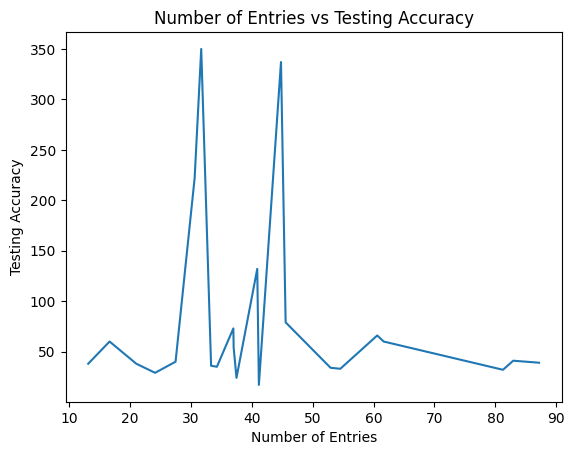

In [133]:
# Plot validation accuracy vs number of entries
# Plot number of entries vs testing accuracy
plt.plot([result['validation_accuracy'] for _, result in best_results], [result['num_entries'] for _, result in best_results])
plt.xlabel('Number of Entries')
plt.ylabel('Testing Accuracy')
plt.title('Number of Entries vs Testing Accuracy')
plt.show()
